Plot Example Map for each Rearing Condition

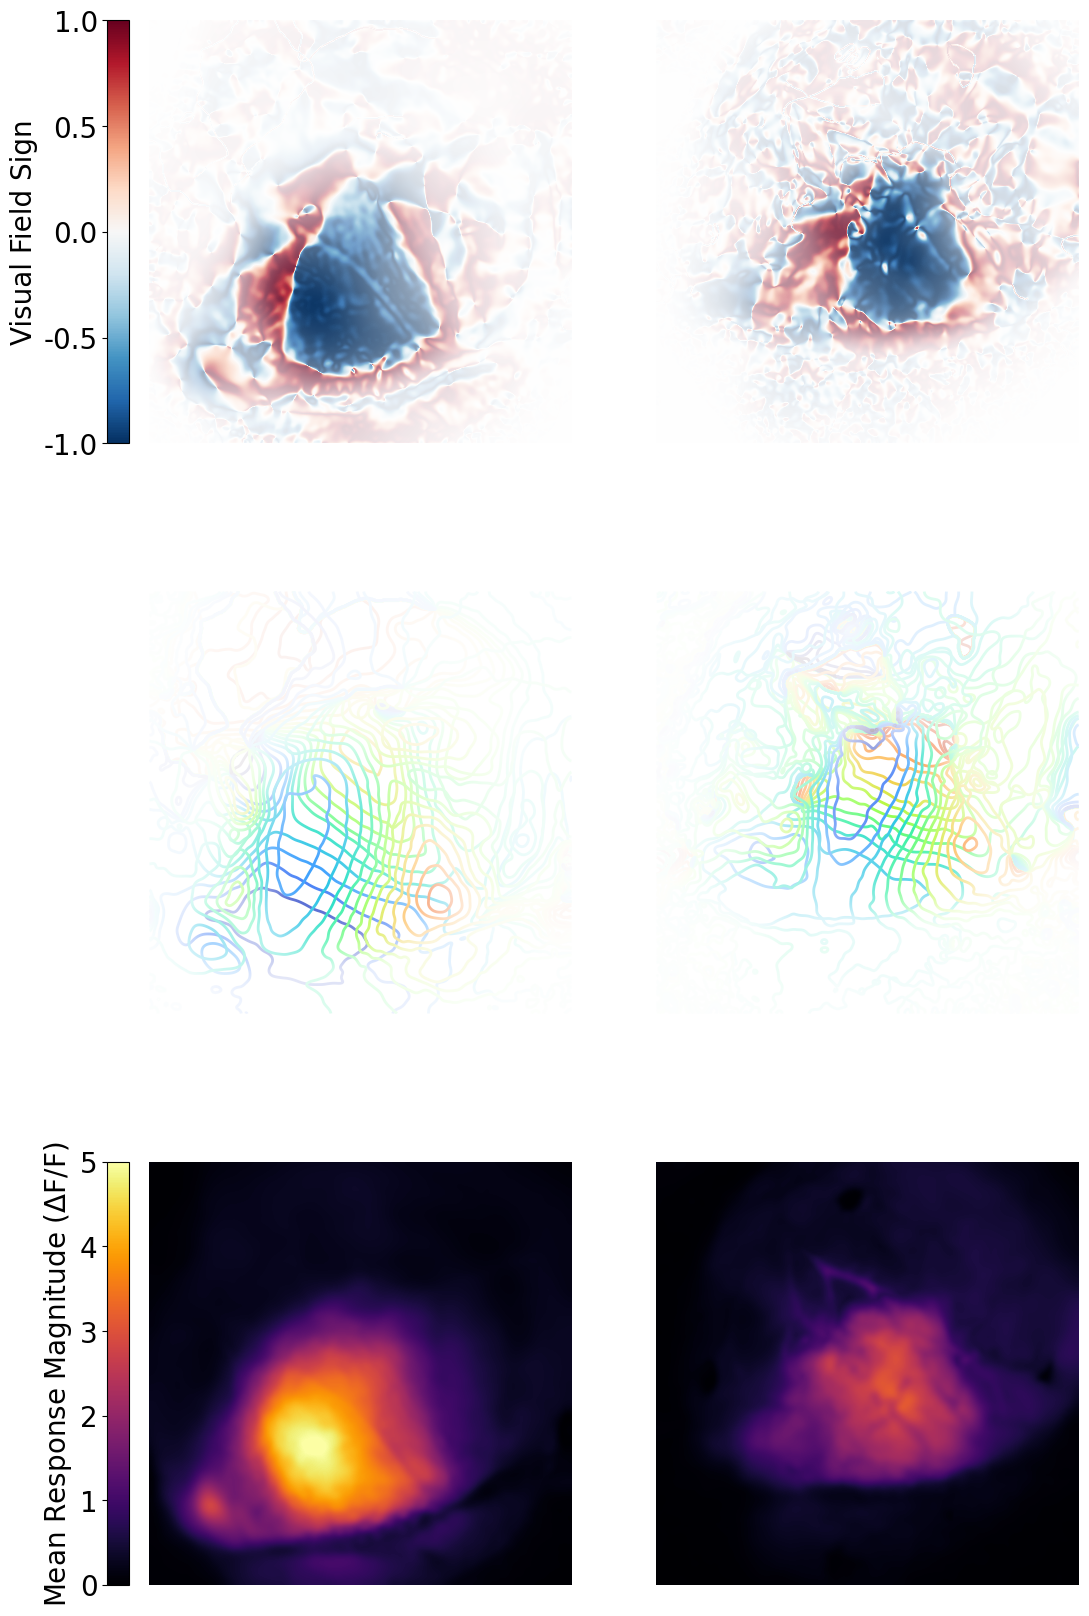

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from tifffile import imread
from skimage import filters

def draw_colorbar(inset_from, mappable, label, num_labels, height, loc, frmt):
    cax = inset_axes(inset_from, width='5%', height=height, loc=loc, borderpad=-3)
    colorbar = fig.colorbar(mappable, cax=cax)
    colorbar.set_label(label, color='k', fontsize=20)
    colorbar.ax.locator_params(nbins=num_labels)
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_major_formatter(FormatStrFormatter(frmt))
    cax.tick_params(labelsize=20)
    return colorbar

exp_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Mapping_Through_Skull/"
examples = ["ctb03/20220623_161247/", 
            "ctb01/20220603_101509/"]
%matplotlib inline
fig, axs = plt.subplots(3, 2)
for ex_num, ex in enumerate(zip(examples, ["NR", "DR"])):
    ref_frame = imread(exp_path + ex[0] + "refframe.tif").squeeze()
    signmap = np.loadtxt(exp_path + ex[0] + "signmap.csv")
    azimuth = np.loadtxt(exp_path + ex[0] + "azimuth.csv")
    elevation = np.loadtxt(exp_path + ex[0] + "elevation.csv")
    avg_mag = np.loadtxt(exp_path + ex[0] + "avg_mag.csv")*100
    alphas = filters.gaussian((avg_mag/np.max(avg_mag)), 10)
    # Sign Map
    axs[0][ex_num].imshow(signmap, cmap="RdBu_r", alpha=1*alphas, clim=[-1, 1])
    axs[0][ex_num].axis("off")
    if ex_num == 0:
        draw_colorbar(axs[0][ex_num], axs[0][ex_num].images[0], "Visual Field Sign", 5, "100%", "center left", "%.1f")
    # Azimuth/Elevation
    axs[1][ex_num].imshow(elevation, cmap='turbo_r', alpha=1, clim=[0, 100], zorder=-3)
    axs[1][ex_num].imshow(azimuth, cmap='turbo_r', alpha=1, clim=[0, 144], zorder=-3)
    axs[1][ex_num].imshow(np.full((512, 512), 1), cmap="gray", clim=[0, 1], zorder=-2, alpha=1)
    axs[1][ex_num].contour(elevation, levels=np.arange(0, 100, 5), cmap='turbo_r', alpha=1, linewidths=2, zorder=-1)
    axs[1][ex_num].contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='turbo_r', alpha=1, linewidths=2, zorder=-1)
    axs[1][ex_num].imshow(np.full((512, 512), 1), cmap="gray", clim=[0, 1], zorder=1, alpha=1*(1-alphas))
    # cbar = draw_colorbar(axs[1], axs[1].images[1], "Azimuth ($\xb0$)", 6, "50%", "upper left", "%i")
    # cbar.ax.set_yticklabels(np.arange(0, 144, 22.5))
    # draw_colorbar(axs[1], axs[1].images[0], "Elevation ($\xb0$)", 6, "50%", "lower left", "%i")
    # axs[1].imshow(ref_frame, cmap="gray", zorder=1, alpha=(1-alphas))
    axs[1][ex_num].axis("off")
    # Magnitude
    axs[2][ex_num].imshow(avg_mag, cmap="inferno", alpha=1, clim=[0, 5])
    axs[2][ex_num].axis("off")
    if ex_num == 0:
        draw_colorbar(axs[2][ex_num], axs[2][ex_num].images[0], "Mean Response Magnitude ($\Delta$F/F)", 6, "100%", "center left", "%i")
# Set figure parameters.
fig.set_size_inches(12, 21)
# fig.savefig(exp_path + ex[1] + "_example.png")